In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
from scipy.stats import norm
import requests
from io import StringIO
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

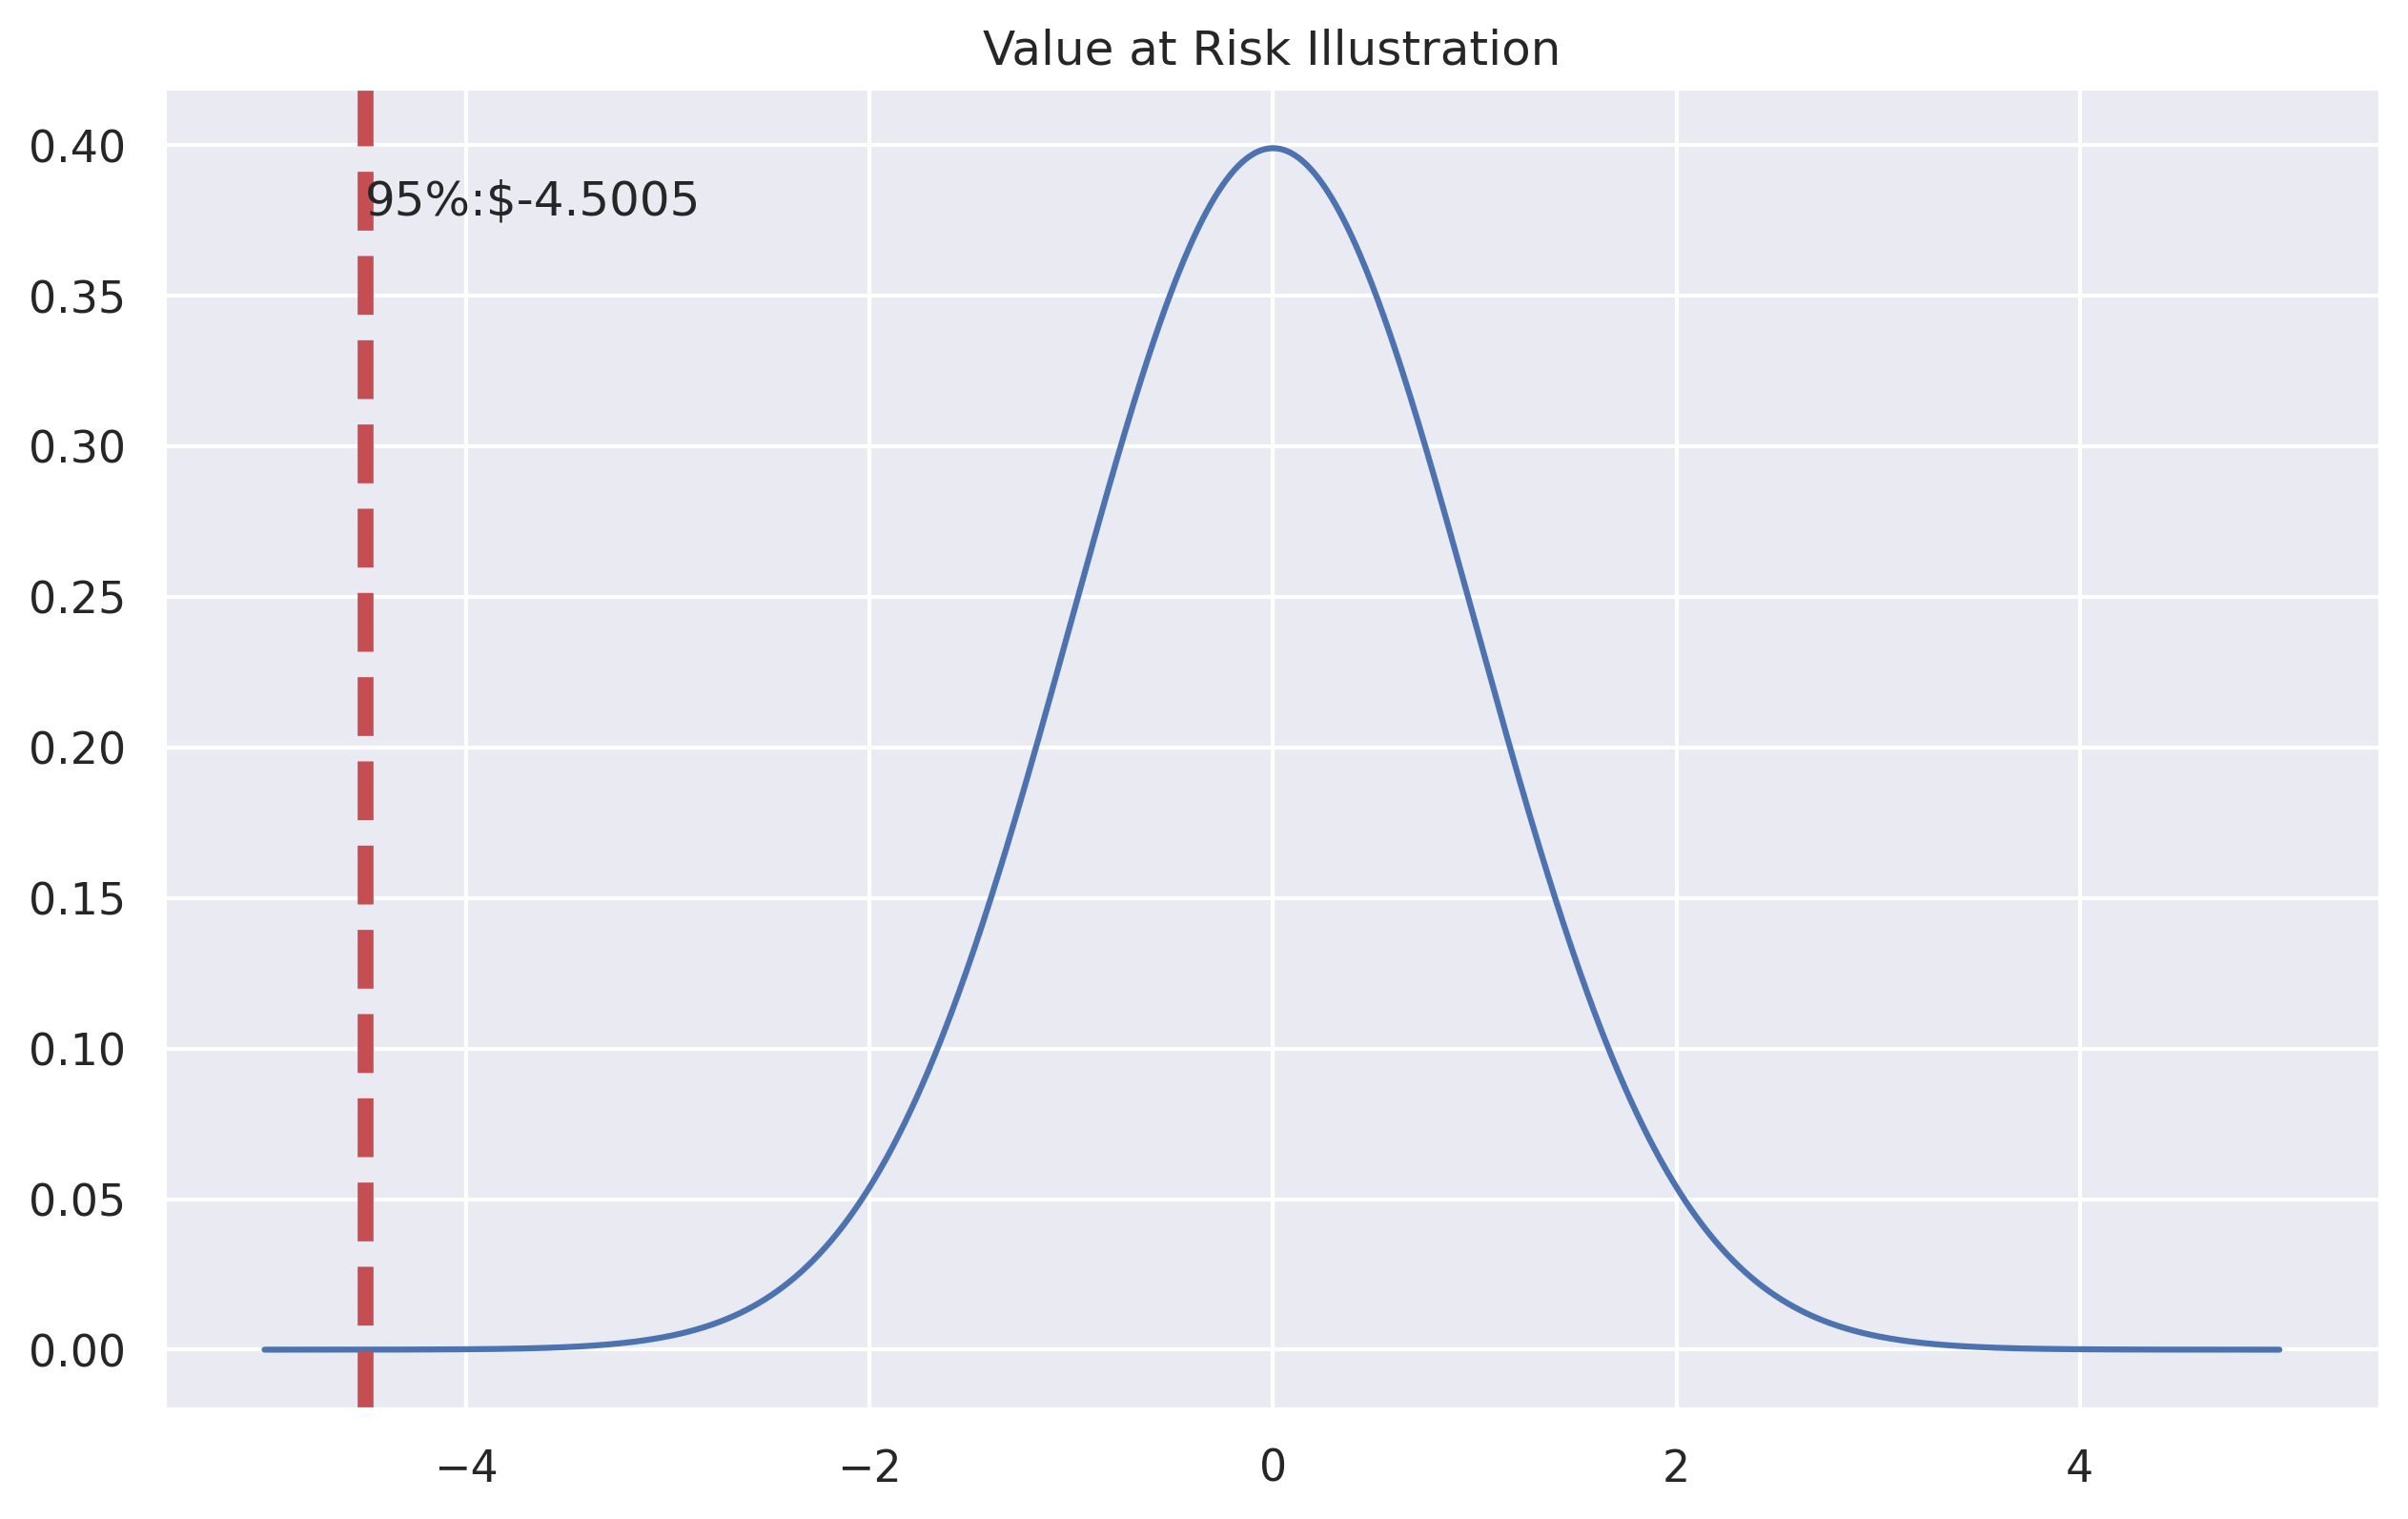

In [3]:
mean = 0
std_dev = 1
x = np.arange(-5, 5, 0.01)
y = norm.pdf(x, mean, std_dev)
pdf = plt.plot(x, y)
min_ylim, max_ylim = plt.ylim()
plt.text(np.percentile(x, 5), max_ylim * 0.9, '95%:${:.4f}'
         .format(np.percentile(x, 5)))
plt.axvline(np.percentile(x, 5), color='r', linestyle='dashed',
            linewidth=4)
plt.title('Value at Risk Illustration')
plt.show()

In [61]:
import refinitiv.data as rd
rd.open_session()

RICS = ['V.N']
ts = rd.get_data(RICS,
                   [
                    'TR.PriceClose(SDate=2021-01-02,EDate=2024-10-14,Frq=D).date',
                    'TR.PriceClose(SDate=2021-01-02,EDate=2024-10-14,Frq=D)'
                   ])
ts2 = ts.drop_duplicates()
ts2

,Instrument,Date,Price Close
0,V.N,2021-01-04,217.76
1,V.N,2021-01-05,214.51
2,V.N,2021-01-06,212.62
3,V.N,2021-01-07,213.81
4,V.N,2021-01-08,215.45
...,...,...,...
946,V.N,2024-10-08,274.96
947,V.N,2024-10-09,276.93
948,V.N,2024-10-10,277.47
949,V.N,2024-10-11,277.84


In [62]:
stocks = ts2.pivot(index="Date", columns="Instrument", values="Price Close")
stocks

Instrument,V.N
Date,
2021-01-04,217.76
2021-01-05,214.51
2021-01-06,212.62
2021-01-07,213.81
2021-01-08,215.45
...,...
2024-10-08,274.96
2024-10-09,276.93
2024-10-10,277.47


In [63]:
stocks_returns = (np.log(stocks) - np.log(stocks.shift(1))).dropna()
stocks_returns

Instrument,V.N
Date,
2021-01-05,-0.015037
2021-01-06,-0.00885
2021-01-07,0.005581
2021-01-08,0.007641
2021-01-11,-0.011953
...,...
2024-10-08,0.004264
2024-10-09,0.007139
2024-10-10,0.001948


In [65]:
stocks_returns_mean = stocks_returns.mean()
weights  = np.random.random(len(stocks_returns.columns))
weights /= np.sum(weights)
#weights =  np.array([.333, .333, .333], dtype='float')
cov_var = stocks_returns.cov()
port_std = np.sqrt(weights.T.dot(cov_var).dot(weights))

In [66]:
type(weights)

numpy.ndarray

In [67]:
#stocks_returns_mean
#weights
#cov_var
port_std

0.014449925587713007

In [68]:
initial_investment = 1000000
conf_level = 0.95

In [69]:
alpha = norm.ppf(.05, stocks_returns_mean, port_std)

In [70]:
alpha

array([-0.02350083])

In [71]:
stocks.columns

Index(['V.N'], dtype='object', name='Instrument')

## Variance-Covariance Method

In [72]:
for i, j in zip(stocks.columns, range(len(stocks.columns))):
    VaR_param = (initial_investment - initial_investment * 
                     (1 + alpha))[j]
    print("Parametric VaR result for {} is {} "
              .format(i, VaR_param))

Parametric VaR result for V.N is 23500.83178425394 


In [73]:
def VaR_parametric(initial_investment, conf_level):
    alpha = norm.ppf(1 - conf_level, stocks_returns_mean, port_std)
    for i, j in zip(stocks.columns, range(len(stocks.columns))):
        VaR_param = (initial_investment - initial_investment * 
                     (1 + alpha))[j]
        print("Parametric VaR result for {} is {} "
              .format(i, VaR_param))
    VaR_param = (initial_investment - initial_investment * (1 + alpha))
    print('--' * 25)
    return VaR_param

In [74]:
VaR_param = VaR_parametric(initial_investment, conf_level)
VaR_param

Parametric VaR result for V.N is 23500.83178425394 
--------------------------------------------------


array([23500.83178425])

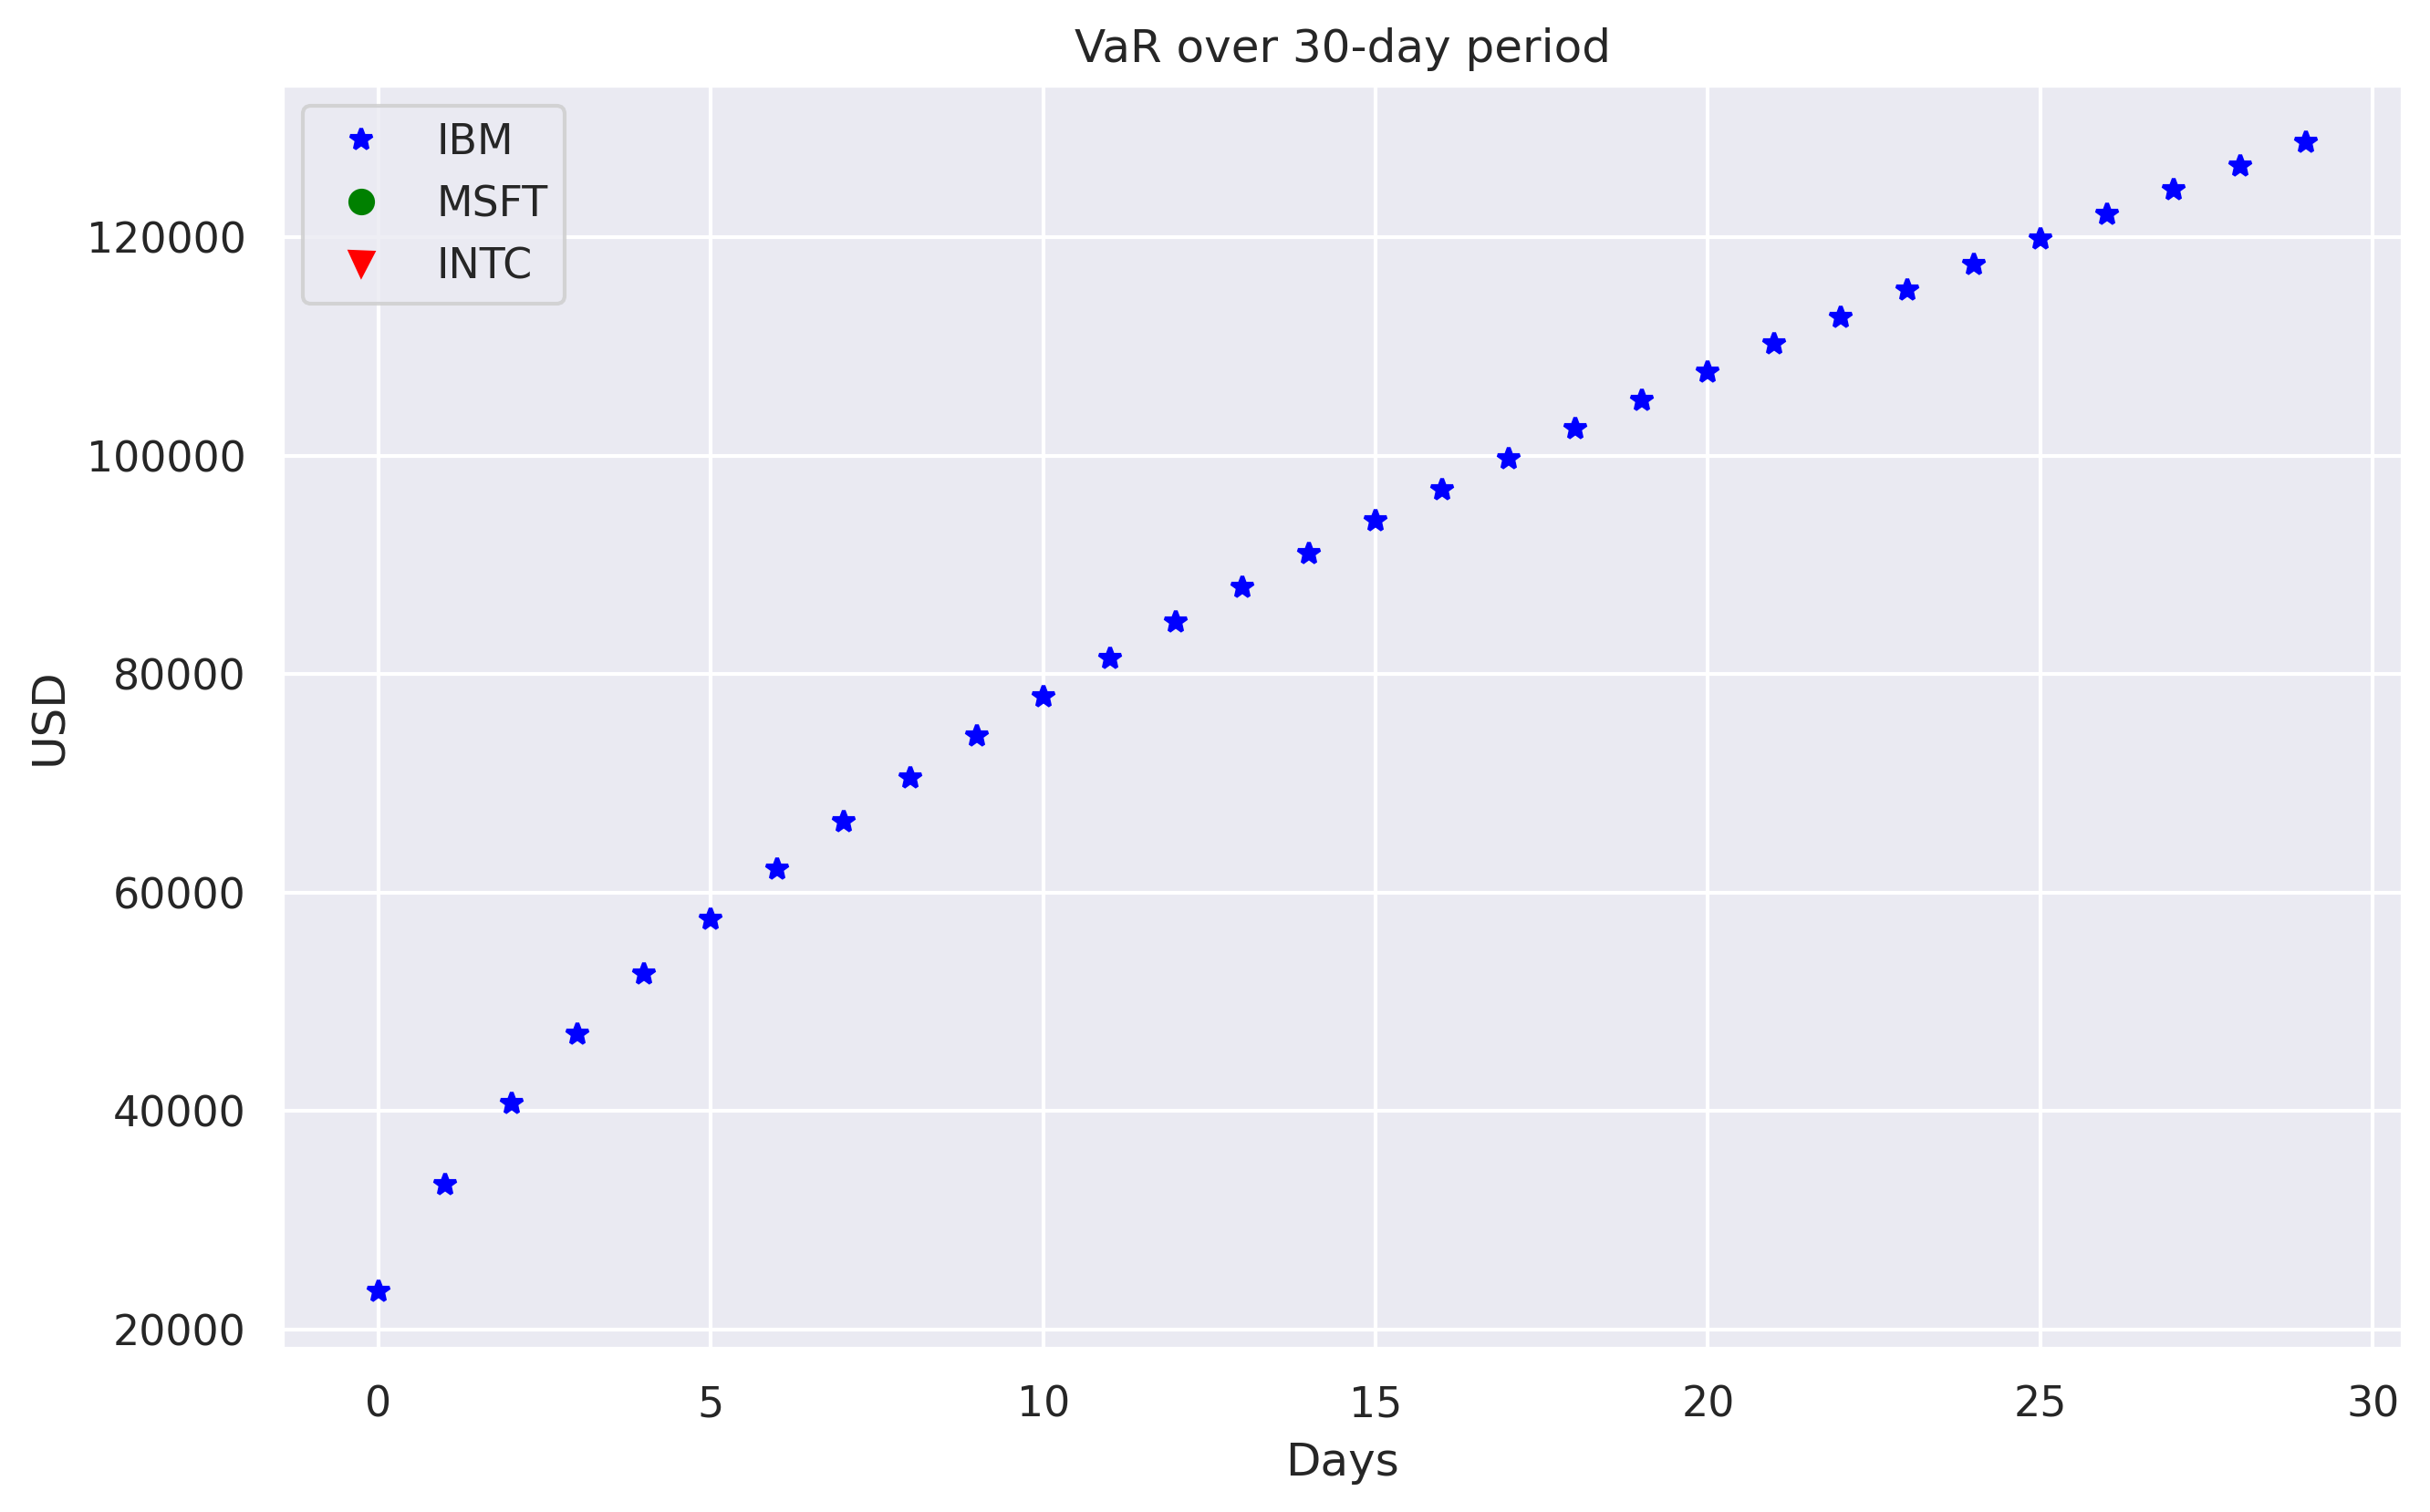

In [75]:
var_horizon = []
time_horizon = 30
for j in range(len(stocks_returns.columns)):
    for i in range(1, time_horizon + 1):
        var_horizon.append(VaR_param[j] * np.sqrt(i))
plt.plot(var_horizon[:time_horizon], "o",
         c='blue', marker='*', label='IBM')
plt.plot(var_horizon[time_horizon:time_horizon + 30], "o",
         c='green', marker='o', label='MSFT')
plt.plot(var_horizon[time_horizon + 30:time_horizon + 60], "o",
         c='red', marker='v', label='INTC')
plt.xlabel("Days")
plt.ylabel("USD")
plt.title("VaR over 30-day period")
plt.legend()
plt.show()

## Historical


In [76]:
for i, j in zip(stocks_returns.columns,
                    range(len(stocks_returns.columns))):
    print(np.percentile(stocks_returns.loc[:, i], 5))

-0.024105664968810902


In [77]:
stocks_returns.loc[:, 'V.N']

Date
2021-01-05   -0.015037
2021-01-06    -0.00885
2021-01-07    0.005581
2021-01-08    0.007641
2021-01-11   -0.011953
                ...   
2024-10-08    0.004264
2024-10-09    0.007139
2024-10-10    0.001948
2024-10-11    0.001333
2024-10-14     0.01017
Name: V.N, Length: 950, dtype: Float64

In [78]:
np.percentile(stocks_returns.loc[:, 'V.N'], 5)

-0.024105664968810902

In [79]:
def VaR_historical(initial_investment, conf_level):
    Hist_percentile95 = []
    for i, j in zip(stocks_returns.columns,
                    range(len(stocks_returns.columns))):
        Hist_percentile95.append(np.percentile(stocks_returns.loc[:, i],
                                               5))
        print("Based on historical values 95% of {}'s return is {:.4f}"
              .format(i, Hist_percentile95[j]))
        VaR_historical = (initial_investment - initial_investment *
                          (1 + Hist_percentile95[j]))
        print("Historical VaR result for {} is {:.2f} "
              .format(i, VaR_historical))
        print('--' * 35)

In [80]:
VaR_historical(initial_investment,conf_level)

Based on historical values 95% of V.N's return is -0.0241
Historical VaR result for V.N is 24105.66 
----------------------------------------------------------------------


## Monte Carlo VaR

In [81]:
x = np.random.uniform(-1, 1, 100) 
y = np.random.uniform(-1, 1, 100)

In [82]:
sim_data = pd.DataFrame([])
num_reps = 1000
n = 100
for i in range(len(stocks.columns)):
    print(i)

0


In [86]:
sim_data = pd.DataFrame([])
num_reps = 1000
n = 100
for i in range(len(stocks.columns)):
    mean = np.random.randn(n).mean()
    std = np.random.randn(n).std()
    temp = pd.DataFrame(np.random.normal(mean, std, num_reps))
    sim_data = pd.concat([sim_data, temp], axis=1)
sim_data.columns = ['Simulation 1']

In [87]:
sim_data

,Simulation 1
0,-1.880991
1,0.698120
2,-0.907820
3,0.887554
4,2.408244
...,...
995,2.070645
996,0.065431
997,1.141575
998,0.690249


In [88]:
MC_percentile95 = []
for i, j in zip(sim_data.columns, range(len(sim_data.columns))):
    print(i,j)

Simulation 1 0


In [89]:
def MC_VaR(initial_investment, conf_level):
    MC_percentile95 = []
    for i, j in zip(sim_data.columns, range(len(sim_data.columns))):
        MC_percentile95.append(np.percentile(sim_data.loc[:, i], 5))
        print("Based on simulation 95% of {}'s return is {:.4f}"
              .format(i, MC_percentile95[j]))
        VaR_MC = (initial_investment - initial_investment * 
                  (1 + MC_percentile95[j]))
        print("Simulation VaR result for {} is {:.2f} "
              .format(i, VaR_MC))
        print('--' * 35)

In [90]:
MC_VaR(initial_investment, conf_level)

Based on simulation 95% of Simulation 1's return is -1.4401
Simulation VaR result for Simulation 1 is 1440112.72 
----------------------------------------------------------------------
